In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
!pip install unidecode
from unidecode import unidecode
from nltk.corpus import stopwords 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

     |████████████████████████████████| 245kB 6.6MB/s 


In [2]:
%%bash
mkdir ~/.kaggle
mv kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
cat ~/.kaggle/kaggle.json 

{"username":"kristinp9","key":"2b9a20aef527a95c59db004baa4642f5"}

In [4]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 85.2MB/s]


In [6]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [10]:
df = pd.read_csv("Tweets.csv", dtype=str)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [11]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [12]:
df.shape

(14640, 15)

In [13]:
df['count'] = df['text'].str.count(' ') + 1
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,count
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),4
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),9
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),12
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),17
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),10


In [ ]:
df['text'] = df['text'].str.replace(r'#\w+', '').str.replace(r'co', '').str.replace(r'http.?://[^\s]+[\s]?', '').str.replace(r'@\w+', '').str.replace(r'"\w+', '').str.replace("mo", '')
df["text"] = df['text'].str.lower()
df.head()

,user_id,status_id,created_at,screen_name,text,source,is_quote,is_retweet,favorite_count,retweet_count,...,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,urls_url,urls_t_co,clase,count
306149,576528582,1188922604436021249,2019-10-28 20:56:52,alefinocchiaro,gracias a los millones de argentinos que nfiar...,Twitter for iPhone,False,False,292,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,35
231729,73197872,1235614043357859842,2020-03-05 17:11:59,clauavruj,explicó hace años el gran sigmund freud el sig...,Twitter for Android,False,False,9,4,...,NaN,NaN,NaN,NaN,NaN,NaN,urgente24.com/actualidad/pol…,https://t.co/UP6BIKiMKJ,1,47
221855,157479149,786949329588191232,2016-10-14 15:18:35,TatoBrown,benchmarking sobre igualdad de oportunidades p...,Twitter for Android,False,False,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12
155757,95970921,1228710592673873922,2020-02-15 16:00:08,pabloavelluto,"por qué no probás n pensar? dale, vos podés. ...",Twitter for iPad,False,False,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11
248610,1132308934948282368,1352723144453337088,2021-01-22 21:01:44,FrenteDeTodos,el miérles recibí la segunda dosis de mi vacun...,Twitter for iPhone,False,True,0,1030,...,1245270.0,314.0,5052.0,NaN,Gobernador de la Provincia de Buenos Aires.,True,NaN,NaN,1,48


In [14]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', height=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count
---------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  19.844520  5.997104  2.0  16.0  21.0  24.0  36.0
neutral            3099.0  14.515650  7.023248  2.0   9.0  14.0  20.0  32.0
positive           2363.0  14.138383  7.108085  2.0   8.0  14.0  20.0  31.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


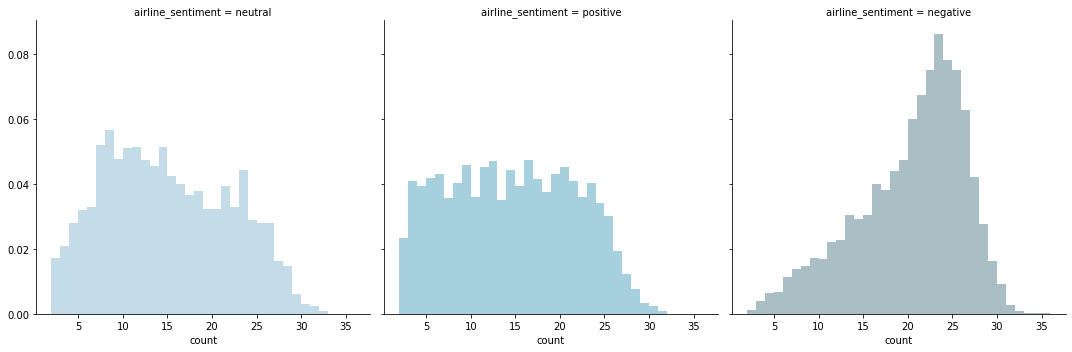

In [15]:
show_dist(df, 'count')

In [23]:
import re
!pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Quitamos palabras que no tengan valor semántico como artículos, preposiciones, conectores. Quitamos usuario mencionado con @, quitamos links y urls publicadas

In [43]:
class CleanText(BaseEstimator, TransformerMixin):
    @staticmethod
    def _remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

    @staticmethod
    def _remove_urls(input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    @staticmethod
    def _remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        whitelist = [["n't", "not", "no"]]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)

    @staticmethod
    def _remove_digits(input_text):
        return re.sub('\d+', '', input_text)

    @staticmethod
    def _to_lower(input_text):
        return input_text.lower()
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self._remove_mentions).apply(self._remove_urls).apply(self._remove_stopwords).apply(self._remove_digits).apply(self._to_lower)
        return clean_X
    

ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

11746    told gates open #ord, needed wait mins. still ...
11393     what's point baggage claim ticket scan tracking?
5629     another ride sw employee printed boarding pass...
4791     needs train employees lease somewhat empatheti...
6788     trouble signing trueblue today, despite right ...
Name: text, dtype: object

## Palabras más frecuentes

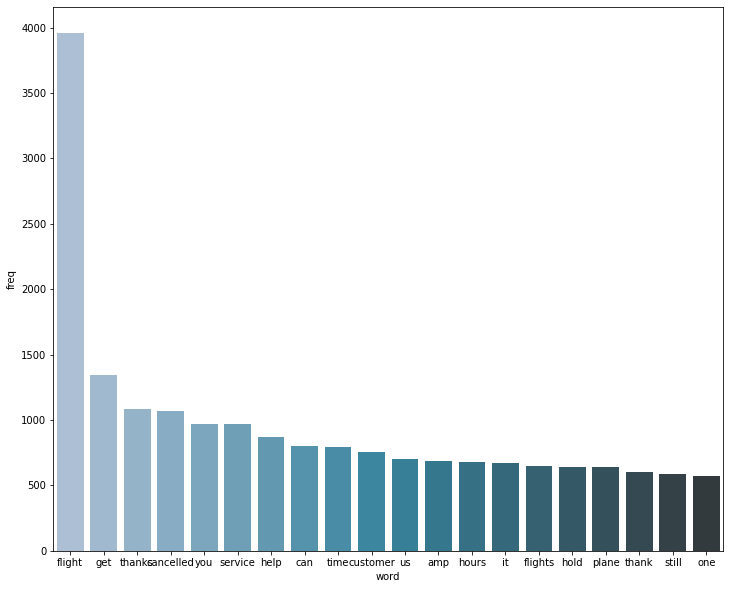

In [25]:
import collections

cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [ ]:
df=df.sample(frac=0.3)
df.shape

(10392, 37)

In [29]:
df.airline_sentiment.value_counts() #positivos y neutrales en una clase para hacer observaciones bianarias

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [31]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'neutral':'positive'})
df.airline_sentiment.value_counts()

negative    9178
positive    5462
Name: airline_sentiment, dtype: int64

## Modelo TfidVerctorizer
### Esto además de la frecuencia tiene en cuenta el peso de la palabra si figura menos veces

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = stopwords.words('english');

Train,Test=train_test_split(df[['text','airline_sentiment']],stratify=df['airline_sentiment'],random_state=3);

Train.reset_index(drop=True,inplace=True);
Test.reset_index(drop=True,inplace=True);

tvectorizer=TfidfVectorizer(strip_accents='unicode',stop_words=stop_words);
tvectorizer.fit(Train['text']);

X_train=tvectorizer.transform(Train['text']);
X_test=tvectorizer.transform(Test['text']);

y_train=Train['airline_sentiment'];
y_test=Test['airline_sentiment'];

NBC=MultinomialNB();

NBC.fit(X_train.todense(),Train['airline_sentiment']);

test_pred=NBC.predict(X_test.todense());

print('Training set shape:',X_train.shape)

print('\nTest Accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nConfusion Matrix:\n',confusion_matrix(Test['airline_sentiment'],test_pred))


Training set shape: (10980, 12617)

Test Accuracy: 0.7825136612021858

Confusion Matrix:
 [[2248   47]
 [ 749  616]]


In [33]:
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True);

params={'alpha':np.arange(0.1,2,0.1)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;
best_model.fit(X_train,y_train); # entrenamos en todo el training set

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nconfusion:\n',confusion_matrix(Test['airline_sentiment'],test_pred))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best score: 0.8004553734061931
best params: {'alpha': 0.2}

Test set:

accuracy: 0.8109289617486338

confusion:
 [[2177  118]
 [ 574  791]]


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    2.2s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Términos representativos de negativos:

['worst' 'ridiculous' 'unacceptable' 'worse' 'suck' 'hr' 'hours' 'hold'
 'fail' 'communication' 'automated' 'hrs' 'rude' 'tarmac' 'disappointed'
 'fuck' 'answers' 'lack' 'half' 'neveragain' 'phones' 'useless' 'terrible'
 'hangs' 'pathetic' 'lose' 'lines' 'paid' 'except' 'hour' 'bother'
 'unhappy' 'hung' 'spent' 'lies' 'impossible' 'forced' 'sucks' 'stranded'
 'switched' 'delayed' 'suitcase' 'badservice' 'disconnected' 'ruining'
 'bs' 'incompetent' 'unhelpful' 'nightmare' 'human' 'luggage' 'frustrated'
 'disappointing' 'solution' '40' 'nothing' 'jetway' 'lost' '2hrs'
 'counting' 'denied' 'screw' 'promised' 'feeling' 'incompetence' 'numbers'
 'system' 'hire' 'funds' 'nothappy' 'customers' 'poor' 'unprofessional'
 'waiting' 'joke' 'training' 'waited' 'annoying' '5hrs' 'fix' 'third'
 'twice' 'sitting' 'absurd' 'whose' 'treat' 'wasting' 'prepared'
 'computers' 'canned' 'excuses' 'stuck' 'disgusting' 'loaded'
 'unfriendlyskies' 'courtesy' 'crappy' 'fuc

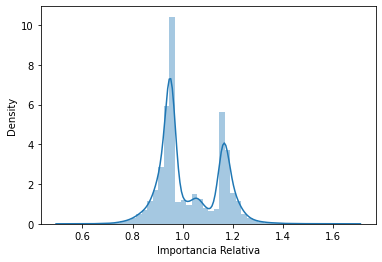

In [35]:
relative_importance=best_model.feature_log_prob_[0]/best_model.feature_log_prob_[1];
#relative_importance < 1 implica que
# el coeficiente asignado en la clase 0 es mayor que en la clase 1 y vicevera

sns.distplot(relative_importance)
plt.xlabel('Importancia Relativa')

features=np.array(tvectorizer.get_feature_names());

indices=np.argsort(relative_importance);

print('Términos representativos de negativos:\n')
print(features[indices[:100]])

print('\nTérminos representativos de neutrales/positivos:\n')
print(features[indices[-100:]])


## Modelo CountVectorizer

In [37]:
stop_words = stopwords.words('english');

Train,Test=train_test_split(df[['text','airline_sentiment']],stratify=df['airline_sentiment'],random_state=3);

Train.reset_index(drop=True,inplace=True);
Test.reset_index(drop=True,inplace=True);

vectorizer=CountVectorizer(strip_accents='unicode',stop_words=stop_words);
vectorizer.fit(Train['text']);

X_train=vectorizer.transform(Train['text']);
X_test=vectorizer.transform(Test['text']);

y_train=Train['airline_sentiment'];
y_test=Test['airline_sentiment'];

NBC=MultinomialNB();

NBC.fit(X_train.todense(),Train['airline_sentiment']);

test_pred=NBC.predict(X_test.todense());

print('Training set shape:',X_train.shape)

print('\nTest Accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nConfusion Matrix:\n',confusion_matrix(Test['airline_sentiment'],test_pred))


Training set shape: (10980, 12617)

Test Accuracy: 0.8202185792349727

Confusion Matrix:
 [[2127  168]
 [ 490  875]]


In [38]:
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True);

params={'alpha':np.arange(0.1,2,0.1)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;
best_model.fit(X_train,y_train); # entrenamos en todo el training set

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nconfusion:\n',confusion_matrix(Test['airline_sentiment'],test_pred))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best score: 0.8094717668488159
best params: {'alpha': 0.30000000000000004}

Test set:

accuracy: 0.8207650273224044

confusion:
 [[2075  220]
 [ 436  929]]


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    1.3s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Términos representativos de negativos:

['worst' 'ridiculous' 'unacceptable' 'hr' 'worse' 'communication' 'hours'
 'automated' 'suck' 'fail' 'hold' 'answers' 'rude' 'tarmac' 'neveragain'
 'phones' 'useless' 'lines' 'hrs' 'hangs' 'forced' 'fuck' 'disappointed'
 'unhappy' 'except' 'lies' 'pathetic' 'lack' 'half' 'switched' 'bother'
 'impossible' 'suitcase' 'badservice' 'bs' 'denied' 'disappointing'
 'ruining' 'unhelpful' 'promised' 'incompetent' '2hrs' 'nightmare'
 'jetway' '5hrs' 'screw' 'incompetence' 'solution' 'delayed' 'training'
 'nothappy' 'hire' 'numbers' 'unprofessional' 'funds' 'hung' 'hour'
 'spent' 'lose' 'paid' 'terrible' 'annoying' 'disgusting' 'third'
 'courtesy' 'whose' 'feeling' 'frustrated' 'stranded' 'computers' 'crappy'
 '400' 'wasting' 'reimbursement' 'badcustomerservice' '3hrs' 'english'
 'absurd' 'diff' '70' 'prepared' 'stopped' 'unfriendlyskies' 'inside'
 'dirty' 'sleeping' 'human' 'luggage' 'mins' 'fix' 'broken' 'canned'
 'drove' 'hostage' 'hotels' 'nasty' 'disgu

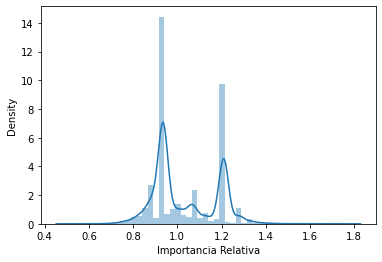

In [39]:
relative_importance=best_model.feature_log_prob_[0]/best_model.feature_log_prob_[1];
#relative_importance < 1 implica que
# el coeficiente asignado en la clase 0 es mayor que en la clase 1 y vicevera

sns.distplot(relative_importance)
plt.xlabel('Importancia Relativa')

features=np.array(vectorizer.get_feature_names());

indices=np.argsort(relative_importance);

print('Términos representativos de negativos:\n')
print(features[indices[:100]])

print('\nTérminos representativos de neutrales/positivos:\n')
print(features[indices[-100:]])
